# Proyecto 2
## RSNA 2022 Cervical Spine Fracture Detection
**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Data Science**

# Entrenamiento de Modelo Base EfficientNetV2 de PyTorch
---

## Integrantes
- Gustavo Gonzalez
- Pablo Orellana
- Diego Leiva
- Maria Ramirez

---

Este notebook contiene el codigo necesario para entrenar un modelo EfficientNetV2 de deteccion de fracturas en tomografias

## Dependencias

In [1]:
try:
    import pylibjpeg
except:
    # Dependencias para extraccion de JPEG y TorchVision
    # Dependencias de https://www.kaggle.com/code/vslaykovsky/rsna-2022-whl
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

Processing /kaggle/input/rsna-2022-whl/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/rsna-2022-whl/torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/rsna-2022-whl/torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [2]:
# Sistema y archivos
import gc
import os
import glob

# Manejo de Imagenes DICOM
import cv2
import pydicom as dicom

# Utilidades
import re

# Visualizaciones de Python
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Manejo de Datos
import numpy as np
import pandas as pd

# PyTorch y CUDA
import torch
import torchvision as tv
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.feature_extraction import create_feature_extractor

# Scikit Learn Para los Folds
from sklearn.model_selection import GroupKFold

## Constantes

In [3]:
# Configuracion para display de pandas
plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# Pesos y Checkpoints de Efficient Net 
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT
EFFNET_CHECKPOINTS_PATH = '../input/rsna-2022-base-effnetv2'

# Rutas de Archivos base
RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
METADATA_PATH = '../input/vertebraeinfer-metadata'

# Constantes para EfficientNet
EFFNET_MAX_TRAIN_BATCHES = 4000
EFFNET_MAX_EVAL_BATCHES = 200
ONE_CYCLE_MAX_LR = 0.0001
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 1000
FRAC_LOSS_WEIGHT = 2.
N_FOLDS = 5
PREDICT_MAX_BATCHES = 1e9

## Configuracion de CUDA

In [4]:
# Configuracion y deteccion de CUDA
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2

## Carga de Conjunto de datos de entrenamiento y evaluacion

- Se cargan los dataset de entrenamiento de la competencia `train.csv`
- Se cargan los metadatos generados en el notebook de inferencia  `vertebraeMetadataEffNet.csv`

In [5]:
# Carga de dataset de entrenamiento de competencia
df_train = pd.read_csv(f'{RSNA_2022_PATH}/train.csv')
df_train.sample(2)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
505,1.2.826.0.1.3680043.15386,0,0,0,0,0,0,0,0
844,1.2.826.0.1.3680043.23715,1,0,0,0,0,0,0,1


In [6]:
# Metadatos de corte de tomografia generados con la inferencia de vertebras
# Contiene las probabilidades de cada vertebra cervical C1-C7 presente en la imagen
# El modelo final genero una precision del 95%
df_train_slices = pd.read_csv(f'{METADATA_PATH}/vertebrae_metadataEffNet.csv')
c1c7 = [f'C{i}' for i in range(1, 8)]
df_train_slices[c1c7] = (df_train_slices[c1c7] > 0.5).astype(int)
display(df_train_slices.sample(5)[['StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']])

,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7
384777,1.2.826.0.1.3680043.25987,0,0,0,1,0,0,0
571662,1.2.826.0.1.3680043.4167,0,1,0,0,0,0,0
578055,1.2.826.0.1.3680043.4438,0,0,0,0,0,0,0
564571,1.2.826.0.1.3680043.3850,0,1,1,0,0,0,0
517456,1.2.826.0.1.3680043.31450,0,0,0,0,0,0,0


El estudio con ID `1.2.826.0.1.3680043.20574` se eliminara del conjunto de datos debido a que no tiene un escaneo cervical completo.

Discusion de Kaggle con detalles - https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344862

In [7]:
# Combinacion de Metadatos y Datos
df_train = df_train_slices.set_index('StudyInstanceUID').join(df_train.set_index('StudyInstanceUID'),
                                                              rsuffix='_fracture').reset_index().copy()
# Eliminacion de estudio incompleto
df_train = df_train.query('StudyInstanceUID != "1.2.826.0.1.3680043.20574"').reset_index(drop=True)
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture
553252,1.2.826.0.1.3680043.342,195,512,512,0.625,-54.4,-26.9,-87.000,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0
328187,1.2.826.0.1.3680043.23597,26,512,512,0.625,-124.3,-100.0,171.625,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


### Split de Datos con Folds

In [8]:
split = GroupKFold(N_FOLDS)
for k, (_, test_idx) in enumerate(split.split(df_train, groups=df_train.StudyInstanceUID)):
    df_train.loc[test_idx, 'split'] = k
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,split
474959,1.2.826.0.1.3680043.29837,18,512,512,1.000,-97.845703,-211.345703,-83.5,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0
677198,1.2.826.0.1.3680043.8477,41,512,512,0.625,-56.000000,-57.500000,-2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0


## Carga de Conjunto de Prueba

- Se cargan los dataset de entrenamiento de la competencia `test.csv`

In [9]:
df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')

if df_test.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
    # Las labels son inconsistentes entre las imagenes y el conjunto de entrenamiento
    df_test = pd.DataFrame({
        "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
        "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
        "prediction_type": ["C1", "C1", "patient_overall"]}
    )

display(df_test)

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,patient_overall


In [10]:
test_slices = glob.glob(f'{TEST_IMAGES_PATH}/*/*')
test_slices = [re.findall(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm', s)[0] for s in test_slices]
df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice'])
df_test_slices.sample(2)

,StudyInstanceUID,Slice
547,1.2.826.0.1.3680043.25399,385
816,1.2.826.0.1.3680043.25399,368


In [11]:
# Unificacion de datos y metadatos asociados
df_test = df_test.set_index('StudyInstanceUID').join(df_test_slices.set_index('StudyInstanceUID')).reset_index()
df_test.sample(2)

,StudyInstanceUID,row_id,prediction_type,Slice
355,1.2.826.0.1.3680043.25399,1.2.826.0.1.3680043.25399_C1,C1,190
958,1.2.826.0.1.3680043.5876,1.2.826.0.1.3680043.5876_C1,patient_overall,79


In [12]:
def load_dicom(path):
    """
    Carga una imagen DICOM y la convierte a RGB.

    Args:
        path (str): Ruta de la imagen DICOM.
    
    Returns:
        img (np.array): Imagen RGB.
        img (pydicom.dataset.FileDataset): Objeto DICOM.
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

## Clase Dataset para PyTorch

La clase `EffnetDataSet` devuelve imágenes de cortes individuales. Usa un parámetro `df` (dataframe) como fuente de metadatos de los cortes para localizar y cargar las imágenes desde una carpeta de rutas. Acepta el parámetro `transforms`, que configuramos con `WEIGHTS.transforms()`. Este conjunto de transformaciones fue utilizado para pre-entrenar el modelo en el conjunto de datos ImageNet.

In [13]:
class EffnetDataSet(torch.utils.data.Dataset):
    """
    Clase para cargar las imágenes de un dataframe con las columnas 'StudyInstanceUID' y 'Slice' y los targets de fracturas
    y vertebras. Se puede pasar un objeto de la clase 'torchvision.transforms' para aplicar transformaciones a las imágenes.

    Args:
        df (pd.DataFrame): Dataframe con las columnas 'StudyInstanceUID' y 'Slice' y los targets de fracturas y vertebras.
        path (str): Ruta donde se encuentran las imágenes.
        transforms (torchvision.transforms): Transformaciones a aplicar a las imágenes. (default: None)

    Returns:
        img (torch.Tensor): Imagen en formato tensor.
        frac_targets (torch.Tensor): Targets de fracturas.
        vert_targets (torch.Tensor): Targets de vertebras.
    """
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')

        try:
            img = load_dicom(path)[0]
            # Pytorch usa el orden (batch, channel, height, width). Convertimos (height, width, channel) -> (channel, height, width)
            img = np.transpose(img, (2, 0, 1))
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))

        except Exception as ex:
            print(ex)
            return None

        # Si se detecta una fractura, se devuelven los targets
        if 'C1_fracture' in self.df:
            frac_targets = torch.as_tensor(self.df.iloc[i][['C1_fracture', 'C2_fracture', 'C3_fracture', 'C4_fracture',
                                                            'C5_fracture', 'C6_fracture', 'C7_fracture']].astype(
                'float32').values)
            # Targets de las vertebras
            vert_targets = torch.as_tensor(
                self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            frac_targets = frac_targets * vert_targets  # Solo se activan los targets que son visibles en la imagen actual
            return img, frac_targets, vert_targets
        return img

    def __len__(self):
        return len(self.df)

In [14]:
# Generar un dataset de prueba
ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y_frac, y_vert = ds_train[42]
print(X.shape, y_frac.shape, y_vert.shape)

torch.Size([3, 384, 384]) torch.Size([7]) torch.Size([7])


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,split
386101,1.2.826.0.1.3680043.26035,1,512,512,0.625,-65.0,-37.6,5.750,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386102,1.2.826.0.1.3680043.26035,2,512,512,0.625,-65.0,-37.6,5.125,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386103,1.2.826.0.1.3680043.26035,3,512,512,0.625,-65.0,-37.6,4.500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386104,1.2.826.0.1.3680043.26035,4,512,512,0.625,-65.0,-37.6,3.875,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386105,1.2.826.0.1.3680043.26035,5,512,512,0.625,-65.0,-37.6,3.250,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386106,1.2.826.0.1.3680043.26035,6,512,512,0.625,-65.0,-37.6,2.625,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386107,1.2.826.0.1.3680043.26035,7,512,512,0.625,-65.0,-37.6,2.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386108,1.2.826.0.1.3680043.26035,8,512,512,0.625,-65.0,-37.6,1.375,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386109,1.2.826.0.1.3680043.26035,9,512,512,0.625,-65.0,-37.6,0.750,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0
386110,1.2.826.0.1.3680043.26035,10,512,512,0.625,-65.0,-37.6,0.125,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0


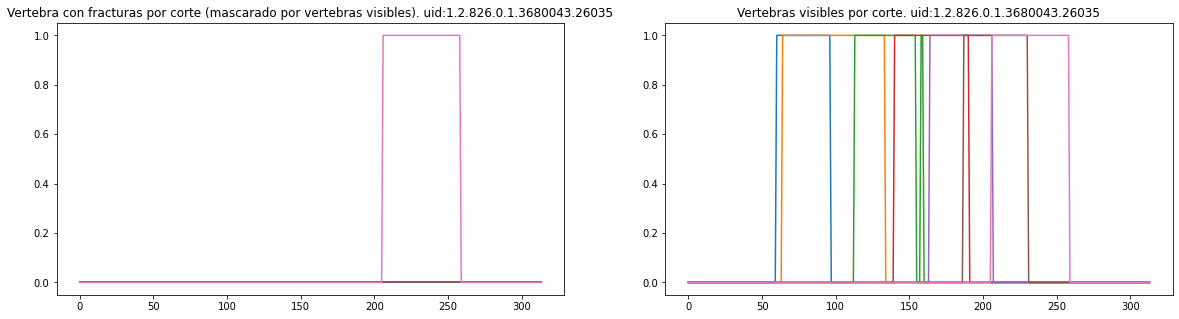

In [15]:
def plot_sample_patient(df, ds):
    """
    Grafica un paciente aleatorio con sus fracturas y vertebras visibles.

    Args:
        df: pd.DataFrame con la información de los pacientes.
        ds: Dataset con las imágenes de los pacientes.
    """
    patient = np.random.choice(df.query('patient_overall > 0').StudyInstanceUID)
    df = df.query('StudyInstanceUID == @patient')
    display(df)

    frac = np.stack([ds[i][1] for i in df.index])
    vert = np.stack([ds[i][2] for i in df.index])
    ax = plt.subplot(1, 2, 1)
    ax.plot(frac)
    ax.set_title(f'Vertebra con fracturas por corte (mascarado por vertebras visibles). uid:{patient}')
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f'Vertebras visibles por corte. uid:{patient}')
    ax.plot(vert)

# Selecciona un paciente aleatorio con fracturas y lo grafica
plot_sample_patient(df_train, ds_train)

In [16]:
# Solo valores X devueltos por el conjunto de datos de prueba
ds_test = EffnetDataSet(df_test, TEST_IMAGES_PATH, WEIGHTS.transforms())
X = ds_test[42]
X.shape

torch.Size([3, 384, 384])

## Modelo Efficient Net V2 para deteccion de Fracturas

En PyTorch se usa **create_feature_extractor** para acceder a las capas de características de modelos preexistentes. La última capa aplanada del modelo `efficientnet_v2_s` se llama `flatten`. Se hara la clasificacion sobre esta.

In [17]:
class EffnetModel(torch.nn.Module):
    """
    Modelo de red neuronal basado en EfficientNetV2-S.


    Args:
        torch (torch.nn.Module): Clase base de PyTorch.

    Attributes:
        model (torch.nn.Module): Modelo de red neuronal EfficientNetV2-S.
        nn_fracture (torch.nn.Module): Red neuronal para clasificación de fracturas.
        nn_vertebrae (torch.nn.Module): Red neuronal para clasificación de vértebras.
    """
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_fracture = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        x = self.model(x)['flatten']
        return self.nn_fracture(x), self.nn_vertebrae(x)

    def predict(self, x):
        frac, vert = self.forward(x)
        return torch.sigmoid(frac), torch.sigmoid(vert)

# Testear el modelo
model = EffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
del model

### Funcion de Perdida

In [18]:
def weighted_loss(y_pred_logit, y, reduction='mean', verbose=False):
    """
    Funcion de perdida con pesos, se reutiliza torch.nn.functional.binary_cross_entropy_with_logits. pos_weight y weights combinados nos dan los coeficientes necesarios.
    """

    # Inicializar los pesos
    neg_weights = (torch.tensor([7., 1, 1, 1, 1, 1, 1, 1]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1])).to(DEVICE)
    pos_weights = (torch.tensor([14., 2, 2, 2, 2, 2, 2, 2]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1]) * 2.).to(DEVICE)

    # Calcular la perdida
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        y_pred_logit,
        y,
        reduction='none',
    )

    if verbose:
        print('loss', loss)
    
    # Aplicar los pesos
    pos_weights = y * pos_weights.unsqueeze(0)
    neg_weights = (1 - y) * neg_weights.unsqueeze(0)
    all_weights = pos_weights + neg_weights

    if verbose:
        print('all weights', all_weights)

    # Multiplicar la perdida por los pesos
    loss *= all_weights
    if verbose:
        print('weighted loss', loss)

    # Normalizar
    norm = torch.sum(all_weights, dim=1).unsqueeze(1)
    if verbose:
        print('normalization factors', norm)

    # Evitar division por cero
    loss /= norm
    if verbose:
        print('normalized loss', loss)

    # Sumar las perdidas
    loss = torch.sum(loss, dim=1)
    if verbose:
        print('summed up over patient_overall-C1-C7 loss', loss)

    # Reduccion
    if reduction == 'mean':
        return torch.mean(loss)
    return loss

## Loop de Entrenamiento/Evaluacion

### Funciones Auxiliares

In [19]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [20]:
def save_model(name, model):
    torch.save(model.state_dict(), f'{name}.tph')

In [21]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [22]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data)
    return model

In [23]:
# quick test
model = torch.nn.Linear(2, 1)
save_model('testmodel', model)

model1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(
    next(iter(model1.parameters())) == next(iter(model.parameters()))
).item(), "Loading/saving is inconsistent!"

### Evaluacion del modelo

In [24]:
def evaluate_effnet(model: EffnetModel, ds, max_batches=PREDICT_MAX_BATCHES, shuffle=False):
    """
    Evalua un modelo de effnet en un dataset de torch.utils.data.Dataset

    Args:
        model: Modelo de effnet a evaluar
        ds: Dataset de torch.utils.data.Dataset
        max_batches: Cantidad má

    Returns:
        float: Loss de fracción de volumen
        float: Loss de vértices
        np.ndarray: Predicciones de fracción de volumen
        np.ndarray: Predicciones de vértices
    """

    # Seteamos la semilla para reproducibilidad
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=os.cpu_count(),
                                          collate_fn=filter_nones)
    
    # Inicializamos las listas de predicciones
    pred_frac = []
    pred_vert = []

    # Evaluamos el modelo
    with torch.no_grad():
        model.eval()
        frac_losses = []
        vert_losses = []
        # Iteramos sobre el dataset de test
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, (X, y_frac, y_vert) in enumerate(progress):
                with autocast():
                    y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                    frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE)).item()
                    vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE)).item()
                    pred_frac.append(torch.sigmoid(y_frac_pred))
                    pred_vert.append(torch.sigmoid(y_vert_pred))
                    frac_losses.append(frac_loss)
                    vert_losses.append(vert_loss)

                if i >= max_batches:
                    break
        # Devolvemos la media de las losses
        return np.mean(frac_losses), np.mean(vert_losses), torch.concat(pred_frac).cpu().numpy(), torch.concat(pred_vert).cpu().numpy()

# Test rapido de evaluacion
m = EffnetModel()
frac_loss, vert_loss, pred1, pred2 = evaluate_effnet(m, ds_train, max_batches=2)
frac_loss, vert_loss, pred1.shape, pred2.shape

Eval:   0%|          | 0/22235 [00:00<?, ?it/s]

(0.6875964601834615, 0.7238050699234009, (96, 7), (96, 7))

### Entrenamiento del modelo

In [25]:
def train_effnet(ds_train, ds_eval, name, logger=None):
    """
    Entrena un modelo EfficientNet en el dataset de entrenamiento ds_train y lo evalúa en el dataset ds_eval.

    Args:
        ds_train: Dataset de entren
        ds_eval: Dataset de evaluación
        name: Nombre del modelo
        logger: Logger de salida

    Returns:
        Modelo entrenado
    """
    # Parámetros de entrenamiento
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(),
                                           collate_fn=filter_nones)

    # Modelo y optimizador y scheduler
    model = EffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1,
                                                    steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)),
                                                    pct_start=ONE_CYCLE_PCT_START)

    # Entrenamiento del modelo
    model.train()
    # Escalador de gradientes
    scaler = GradScaler()

    # Loop de entrenamiento por batches
    with tqdm(dl_train, desc='Train', miniters=10) as progress:
        for batch_idx, (X, y_frac, y_vert) in enumerate(progress):

            # Evaluación del modelo
            if ds_eval is not None and batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
                frac_loss, vert_loss = evaluate_effnet(
                    model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[:2]
                model.train()
                if logger:
                    print({'eval_frac_loss': frac_loss, 'eval_vert_loss': vert_loss, 'eval_loss': frac_loss + vert_loss})
                if batch_idx > 0:
                    save_model(name, model)

            # Fin del entrenamiento
            if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
                break
            
            # Pasos Forward y Backward
            optim.zero_grad()
            with autocast():
                y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE))
                vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))
                loss = FRAC_LOSS_WEIGHT * frac_loss + vert_loss

                if np.isinf(loss.item()) or np.isnan(loss.item()):
                    print(f'Bad loss, skipping the batch {batch_idx}')
                    del loss, frac_loss, vert_loss, y_frac_pred, y_vert_pred
                    gc_collect()
                    continue

            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            scheduler.step()

            progress.set_description(f'Train loss: {loss.item():.02f}')
            if logger:
                print({'loss': loss.item(), 'frac_loss': frac_loss.item(), 'vert_loss': vert_loss.item(),
                       'lr': scheduler.get_last_lr()[0]})

    save_model(name, model)
    return model

In [26]:
effnet_models = []
# Cargar los modelos de effnet previos como checkpoints
for fold in range(N_FOLDS):
    # Si existe un modelo previo, cargarlo
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2-f{fold}.tph')):
        print(f'Found cached version of effnetv2-f{fold}')
        effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH))
    # Si no, entrenar uno nuevo
    else:
        gc_collect()
        ds_train = EffnetDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        effnet_models.append(train_effnet(ds_train, ds_eval, f'effnetv2-f{fold}'))

# Cargar el modelo de effnetv2 como checkpoint
if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, 'effnetv2.tph')):
    print('Found cached version of effnetv2')
    effnet_models.append(load_model(EffnetModel(), 'effnetv2', EFFNET_CHECKPOINTS_PATH))
# Si no, entrenar uno nuevo
else:
    gc_collect()
    ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    train_effnet(ds_train, None, 'effnetv2')

Found cached version of effnetv2-f0
Found cached version of effnetv2-f1
Found cached version of effnetv2-f2
Found cached version of effnetv2-f3
Found cached version of effnetv2-f4
Found cached version of effnetv2


## Evaluacion con validacion Cruzada

In [27]:
effnet_models = []
for name in tqdm(range(N_FOLDS)):
    effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{name}', EFFNET_CHECKPOINTS_PATH))

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
def gen_effnet_predictions(effnet_models, df_train):
    """
    Genera las predicciones de los modelos EfficientNet para el conjunto de entrenamiento.

    Args:
        effnet_models: Lista de modelos EfficientNet.
        df_train: DataFrame con las imágenes de entrenamiento.

    Returns:
        DataFrame con las predicciones de los modelos EfficientNet para el conjunto de entrenamiento.
    """
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv')):
        print('Found cached version of train_predictions.csv')
        df_train_predictions = pd.read_csv(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv'))
    else:
        df_train_predictions = []
        with tqdm(enumerate(effnet_models), total=len(effnet_models), desc='Folds') as progress:
            for fold, effnet_model in progress:
                ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())

                frac_loss, vert_loss, effnet_pred_frac, effnet_pred_vert = evaluate_effnet(effnet_model, ds_eval, PREDICT_MAX_BATCHES)
                progress.set_description(f'Fold score:{frac_loss:.02f}')
                df_effnet_pred = pd.DataFrame(data=np.concatenate([effnet_pred_frac, effnet_pred_vert], axis=1),
                                              columns=[f'C{i}_effnet_frac' for i in range(1, 8)] +
                                                      [f'C{i}_effnet_vert' for i in range(1, 8)])

                df = pd.concat(
                    [df_train.query('split == @fold').head(len(df_effnet_pred)).reset_index(drop=True), df_effnet_pred],
                    axis=1
                ).sort_values(['StudyInstanceUID', 'Slice'])
                df_train_predictions.append(df)
        df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions

In [29]:
df_pred = gen_effnet_predictions(effnet_models, df_train)
df_pred.to_csv('train_predictions.csv', index=False)
df_pred

Found cached version of train_predictions.csv


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,split,C1_effnet_frac,C2_effnet_frac,C3_effnet_frac,C4_effnet_frac,C5_effnet_frac,C6_effnet_frac,C7_effnet_frac,C1_effnet_vert,C2_effnet_vert,C3_effnet_vert,C4_effnet_vert,C5_effnet_vert,C6_effnet_vert,C7_effnet_vert
0,1.2.826.0.1.3680043.10032,1,512,512,0.625,-82.000,11.7120,37.166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000727,0.000883,0.000820,0.000997,0.000693,0.000422,0.000429,0.001040,0.001831,0.003172,0.007347,0.001095,0.000229,0.000194
1,1.2.826.0.1.3680043.10032,2,512,512,0.625,-82.000,11.7120,36.541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000675,0.000807,0.000709,0.000897,0.000600,0.000361,0.000354,0.000922,0.001411,0.002350,0.005200,0.000752,0.000163,0.000147
2,1.2.826.0.1.3680043.10032,3,512,512,0.625,-82.000,11.7120,35.916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000730,0.000869,0.000721,0.000883,0.000624,0.000379,0.000424,0.000915,0.001315,0.002192,0.004757,0.000789,0.000190,0.000194
3,1.2.826.0.1.3680043.10032,4,512,512,0.625,-82.000,11.7120,35.291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000863,0.001147,0.000846,0.001000,0.000638,0.000382,0.000439,0.001129,0.002209,0.002834,0.005120,0.000680,0.000173,0.000203
4,1.2.826.0.1.3680043.10032,5,512,512,0.625,-82.000,11.7120,34.666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000820,0.000940,0.000820,0.001090,0.000707,0.000386,0.000494,0.000925,0.001265,0.002405,0.005688,0.000738,0.000155,0.000220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711498,1.2.826.0.1.3680043.9994,260,512,512,1.000,-130.412,-119.7876,-690.700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.001853,0.001450,0.001216,0.001040,0.000709,0.000575,0.002502,0.001341,0.000577,0.000918,0.000582,0.000162,0.000181,0.000951
711499,1.2.826.0.1.3680043.9994,261,512,512,1.000,-130.412,-119.7876,-691.500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.001315,0.001269,0.001184,0.000922,0.000631,0.000542,0.002846,0.000752,0.000553,0.001124,0.000634,0.000145,0.000185,0.001394
711500,1.2.826.0.1.3680043.9994,262,512,512,1.000,-130.412,-119.7876,-692.300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.001188,0.001037,0.001274,0.001061,0.000735,0.000677,0.004280,0.000548,0.000315,0.001044,0.000856,0.000190,0.000259,0.002672
711501,1.2.826.0.1.3680043.9994,263,512,512,1.000,-130.412,-119.7876,-693.100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.001305,0.001037,0.001507,0.001372,0.000911,0.000770,0.004383,0.000577,0.000278,0.001192,0.001138,0.000257,0.000285,0.002571


In [30]:
def plot_sample_patient(df_pred):
    """
    Grafica un paciente aleatorio con sus predicciones de fracturas y vértebras

    Args:
        df_pred (pd.DataFrame): DataFrame con las predicciones de fracturas y vértebras
    """
    patient = np.random.choice(df_pred.StudyInstanceUID)
    df = df_pred.query('StudyInstanceUID == @patient').reset_index()

    # Primer gráfico: fracturas del paciente
    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(df[[f'C{i}_fracture' for i in range(1, 8)]].values * df[[f'C{i}' for i in range(1, 8)]].values)
    ax1.set_title(f'Patient {patient}, fractures')

    # Segundo gráfico: predicción de fracturas
    df[[f'C{i}_effnet_frac' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, fracture prediction',
        ax=plt.subplot(1, 3, 2)
    )

    # Tercer gráfico: predicción de vértebras
    df[[f'C{i}_effnet_vert' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, vertebrae prediction',
        ax=plt.subplot(1, 3, 3)
    )

    plt.tight_layout()  # Ajusta el layout para que los títulos no se solapen
    plt.show()


### Resultados con pacientes aleatorios

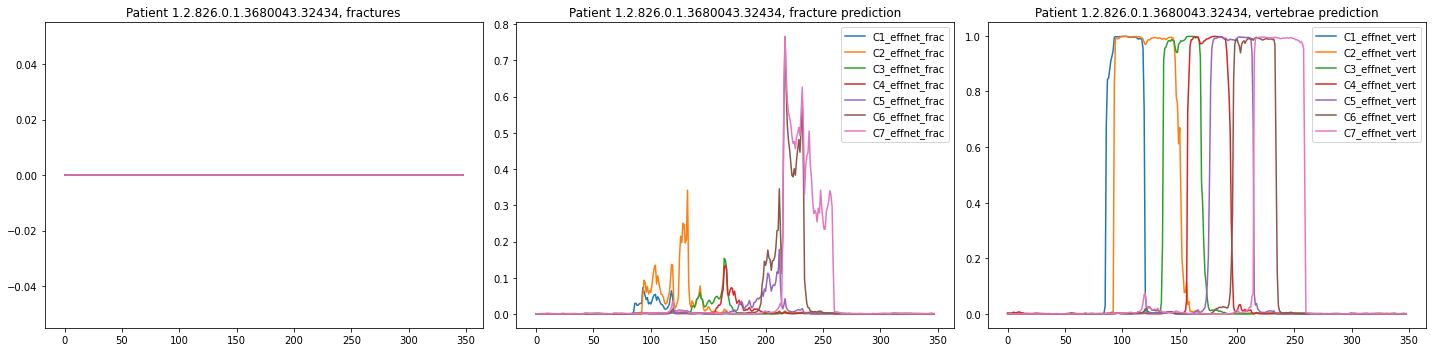

In [31]:

plot_sample_patient(df_pred)

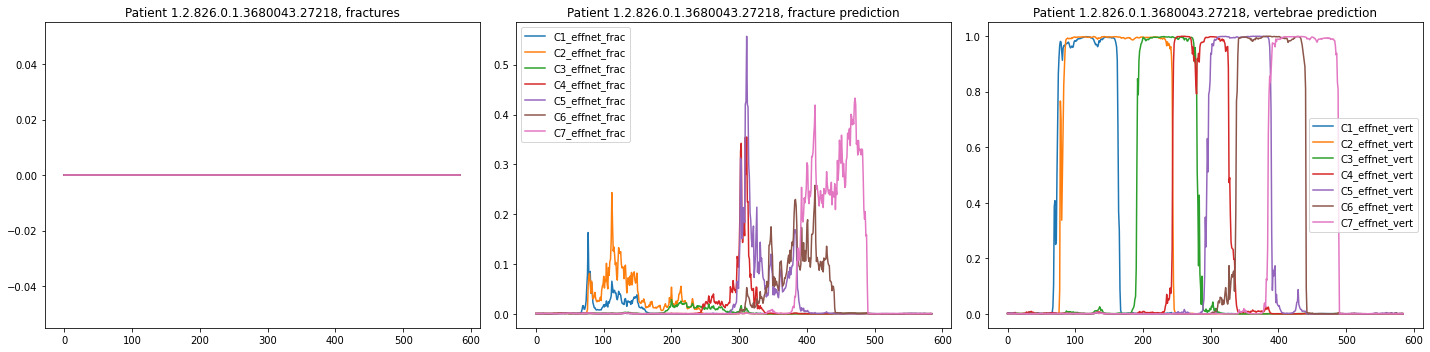

In [32]:
plot_sample_patient(df_pred)

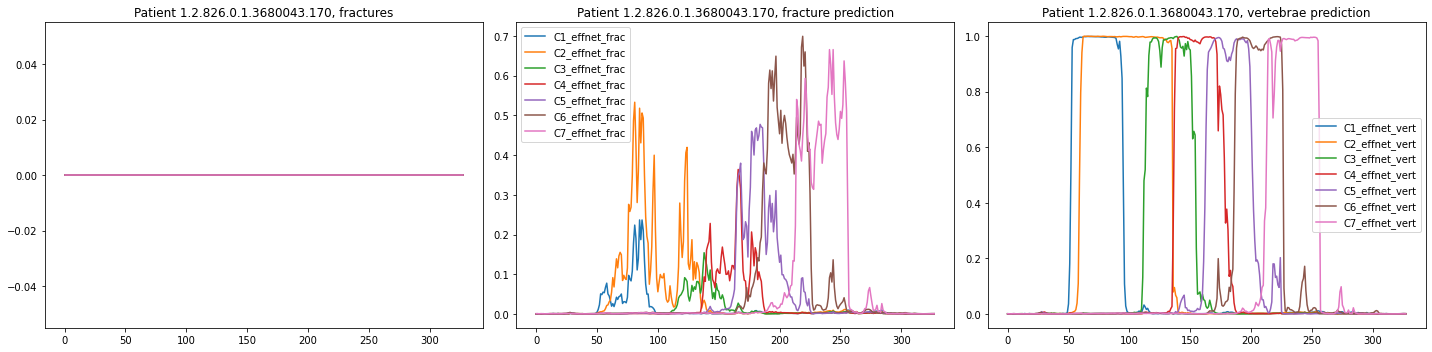

In [33]:
plot_sample_patient(df_pred)

## Generacion de predicciones

In [34]:
target_cols = ['patient_overall'] + [f'C{i}_fracture' for i in range(1, 8)]
frac_cols = [f'C{i}_effnet_frac' for i in range(1, 8)]
vert_cols = [f'C{i}_effnet_vert' for i in range(1, 8)]


def patient_prediction(df):
    c1c7 = np.average(df[frac_cols].values, axis=0, weights=df[vert_cols].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return np.concatenate([[pred_patient_overall], c1c7])

df_patient_pred = df_pred.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df)).to_frame('pred').join(df_pred.groupby('StudyInstanceUID')[target_cols].mean())

In [35]:
display(df_patient_pred.head())

,pred,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture
StudyInstanceUID,,,,,,,,,
1.2.826.0.1.3680043.10001,"[0.6597993086925601, 0.016618907838660275, 0.0...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10005,"[0.5736867044966425, 0.045942942809370294, 0.2...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10014,"[0.45689148601955476, 0.04066260208031813, 0.0...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10016,"[0.2460321392949666, 0.015621005477521474, 0.0...",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1.2.826.0.1.3680043.10032,"[0.43718611420226183, 0.04664682763992611, 0.0...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Pasar a numpy stack
predictions = np.stack(df_patient_pred.pred.values.tolist())

In [37]:
# Generar array de targets
targets = df_patient_pred[target_cols].values

In [38]:
# Obtener el Cross Valdation score
print('CV score:', weighted_loss(torch.logit(torch.as_tensor(predictions)).to(DEVICE), torch.as_tensor(targets).to(DEVICE)))

CV score: tensor(0.4955, device='cuda:0', dtype=torch.float64)
